In [30]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive
Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive


In [31]:
ls

MyDrive/  Shareddrives/
MyDrive/  Shareddrives/


In [32]:
cd/gdrive/MyDrive/Ant vs bees classification/

/gdrive/MyDrive/Ant vs bees classification
/gdrive/MyDrive/Ant vs bees classification


In [33]:
ls

ants/  bees/
 ants/  'Ant vs bees classification.h5'   bees/


In [34]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [35]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Ant vs bees classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 398 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


In [39]:
class_names = dataset.class_names
class_names

['ants', 'bees']

['ants', 'bees']

In [40]:
len(dataset)

7

7

In [41]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[2.71846771e+01 7.17343750e+01 9.20616150e+00]
  [1.26348877e+01 5.71162720e+01 1.13160095e+01]
  [1.24131775e+00 3.74138336e+01 4.82899475e+00]
  ...
  [1.11905167e+02 1.72909073e+02 2.52054474e+02]
  [1.08456772e+02 1.68294662e+02 2.50900131e+02]
  [1.02591797e+02 1.64598221e+02 2.51719879e+02]]

 [[2.69778595e+01 6.58750000e+01 1.21399689e+01]
  [1.19218750e+01 5.70261841e+01 1.32855377e+01]
  [1.72137451e+00 4.24563751e+01 6.01240540e+00]
  ...
  [1.17133469e+02 1.72952469e+02 2.52931641e+02]
  [1.11824219e+02 1.68123825e+02 2.50869919e+02]
  [1.07126953e+02 1.66029556e+02 2.51826172e+02]]

 [[2.66529999e+01 6.43420105e+01 8.23046875e+00]
  [2.18078918e+01 5.65787048e+01 1.41177826e+01]
  [1.01097412e+01 4.86690369e+01 1.29098969e+01]
  ...
  [1.21338333e+02 1.73955521e+02 2.52162109e+02]
  [1.12682938e+02 1.74065765e+02 2.52220718e+02]
  [1.06601562e+02 1.68838760e+02 2.50239365e+02]]

 ...

 [[1.13573792e+02 1.43000473e+02 7.23374786e+01]
  [7.25449

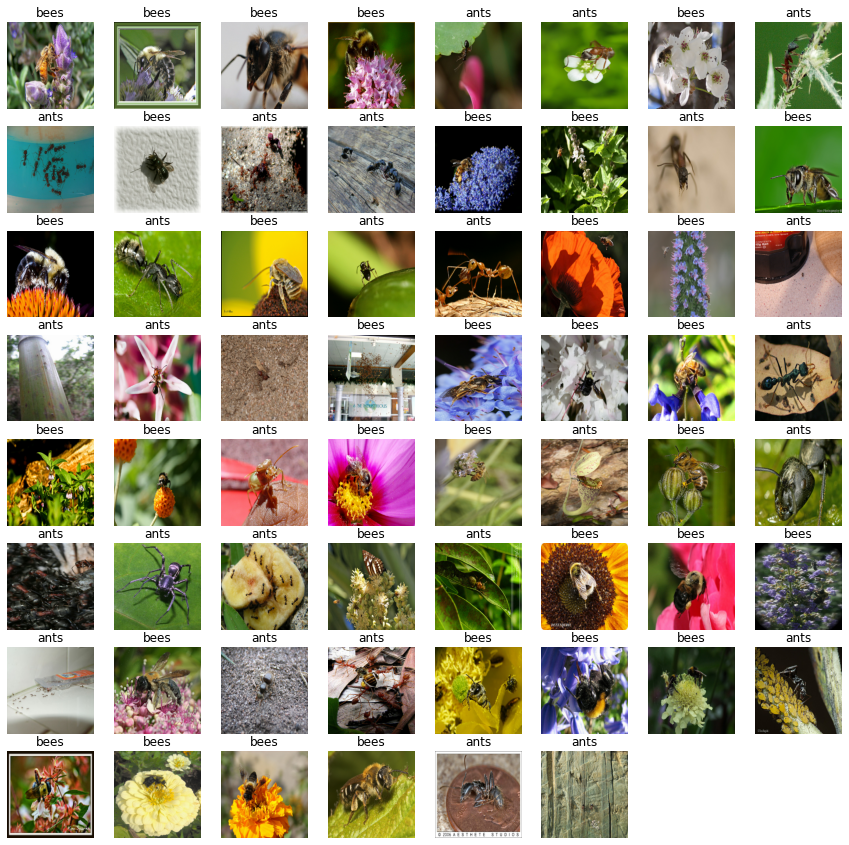

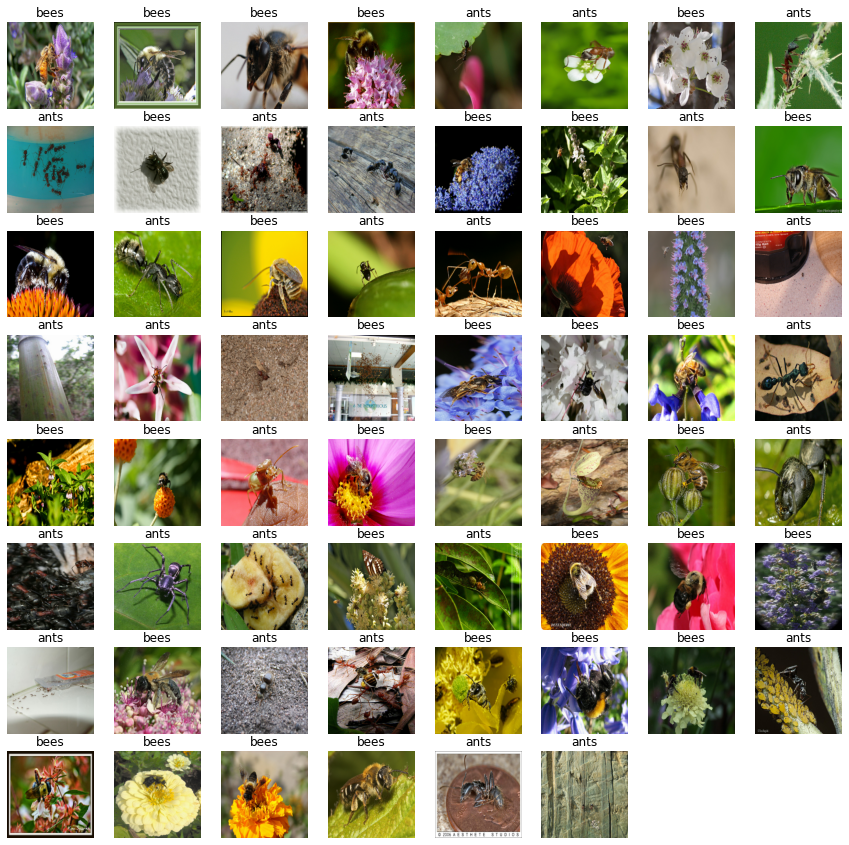

In [42]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [43]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [44]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [45]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [46]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
5/5 [==============================] - 39s 7s/step - loss: 1.7550 - accuracy: 0.3935
Epoch 2/40
5/5 [==============================] - 33s 7s/step - loss: 0.8980 - accuracy: 0.4903
Epoch 3/40
5/5 [==============================] - 33s 7s/step - loss: 0.7725 - accuracy: 0.4742
Epoch 4/40
5/5 [==============================] - 33s 7s/step - loss: 0.7343 - accuracy: 0.5194
Epoch 5/40
5/5 [==============================] - 33s 7s/step - loss: 0.7060 - accuracy: 0.5290
Epoch 6/40
5/5 [==============================] - 33s 7s/step - loss: 0.7056 - accuracy: 0.4806
Epoch 7/40
5/5 [==============================] - 33s 7s/step - loss: 0.6946 - accuracy: 0.5065
Epoch 8/40
5/5 [==============================] - 33s 7s/step - loss: 0.6848 - accuracy: 0.5097
Epoch 9/40
5/5 [==============================] - 33s 7s/step - loss: 0.6804 - accuracy: 0.5613
Epoch 10/40
5/5 [==============================] - 33s 7s/step - loss: 0.6726 - accuracy: 0.5935
Epoch 11/40
5/5 [======================

In [22]:
model.evaluate(test_ds)

2/2 [==============================] - 6s 2s/step - loss: 0.6870 - accuracy: 0.8468


[0.6870157718658447, 0.8467742204666138]

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']

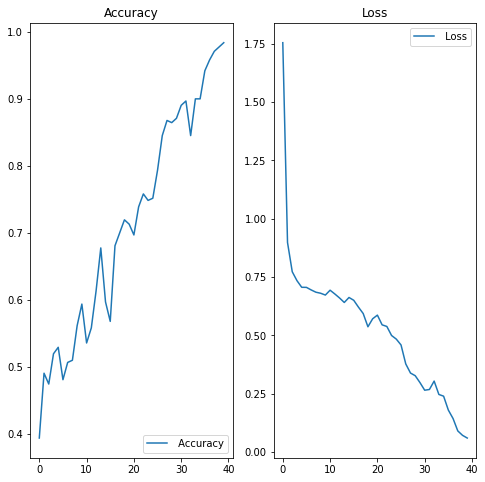

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

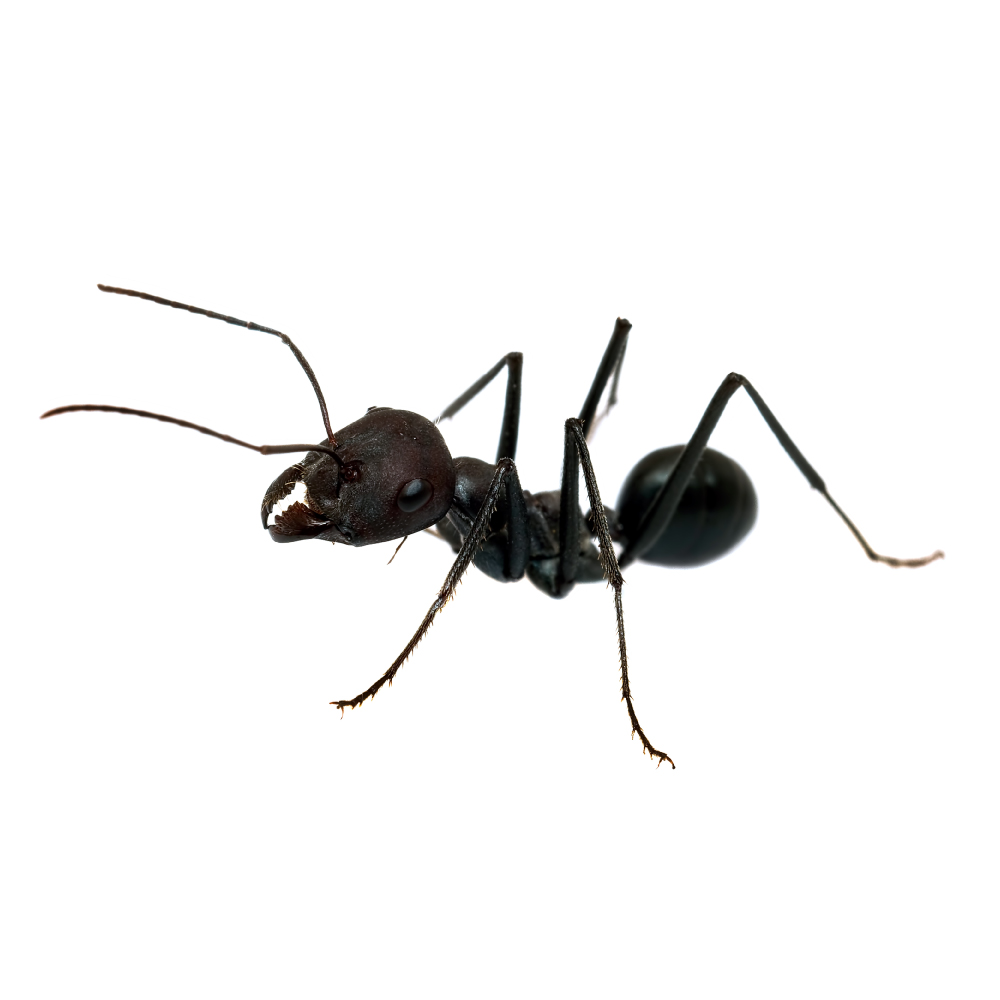

In [25]:
image_path = "/gdrive/My Drive/black-ant-polyrhachis.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [26]:
pred = model.predict(scaled_img)

In [27]:
output = class_names[np.argmax(pred)]

In [28]:
output

'ants'

In [29]:
model.save("Ant vs bees classification.h5")